---
title: Applying logistic regression in Python
---

...from lessons learned from Andrew Ng's [ML course](https://www.youtube.com/watch?v=-la3q9d7AKQ). Like other assignments of the course, the logistic regression assignment used MATLAB. Here, I also translate MATLAB code into Python. I apply the mathematical concepts and the Python code to a datset I evaluated in another [project](https://benslack19.github.io/projects/predicting_states_sc_analysis/#supervised-machine-learning). Check out the project link for more context to this post.

## Import packages and data from project notebook

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I followed this StackOverflow [post](https://stackoverflow.com/questions/31621414/share-data-between-ipython-notebooks) to store and transfer the data from my [activation state project](https://benslack19.github.io/projects/predicting_states_sc_analysis/#supervised-machine-learning) into this Jupyter notebook and post.

In [7]:
# Import data
%store -r X   # This is the entire data  
%store -r y   # This is the activation state label.

no stored variable # This is the entire data
no stored variable # This is the activation state label.


I chose two genes that showed reasonable, but not wide, separation between the groups.

In [63]:
gene1 = 'Plk2'
gene2 = 'Ankrd33b'
X = X.loc[:,[gene1, gene2]]

## Logistic regression functions

I use the naming conventions of the Ng course. The logistic regression model is such that we want the hypothesis to be within the bounds 0 and 1.

$$ 0 \leq h_{\theta}(x) \leq 1$$

If $$ h_{\theta}(x) = g(\theta^Tx) $$ and $$ g(z) = \frac{1}{1 + exp(-z)}\ $$
then

$$ h_{\theta}(x) = \frac{1}{1 + exp(-\theta^Tx)} $$

The objective will be to determine the parameters $\theta$.

To do this, we will minimize the logistic regression cost function

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{(i)}))-(1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))] $$

The gradient equation is $$ \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m} \sum_{i=1}^{m}(h_{\theta}(x^{(i)}))-y^{(i)})x^{(i)}_{j} $$

## Plotting
We start the exercise by first plotting the top two features of the data. Blue is the negative class, red is the positive class.

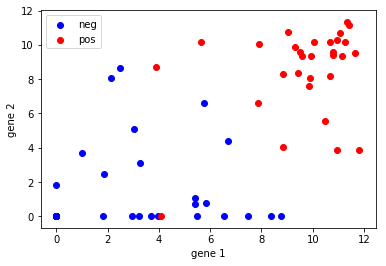

In [68]:
# Matplotlib plotting syntax isdifferent from MATLAB
f, (ax1) = plt.subplots(1,1);
mask = y==0;
ax1.scatter(x=X.loc[mask,gene1], y=X.loc[mask,gene2], color='blue', label='neg');
mask = y==1;
ax1.scatter(x=X.loc[mask,gene1], y=X.loc[mask,gene2], color='red', label='pos');
ax1.set_xlabel('gene 1');
ax1.set_ylabel('gene 2');
ax1.legend();

## Compute Cost and Gradient

These were the directions in the MATLAB code of the ML course assignment:
"In this part of the exercise, you will implement the cost and gradient
for logistic regression. You need to complete the code in costFunction.m."

I'll make each function a separate Jupyter cell.

In [69]:
# Sigmoid function
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [70]:
# Cost function
def costFunction(theta, X, y):
    # Initialize some useful values
    m = len(y);
    J = 0;
    grad = np.zeros(theta.shape)
    
    # -- code exercise from class (MATLAB code commented out)--- 
    # h = sigmoid(X*theta);
    h = sigmoid(np.dot(X, theta)).flatten()  # flatten needed from testing
    # J = 1/m*((-y'*log(h))-(1-y)'*log(1-h)); 
    step1 = np.dot(y.T, np.log(h))
    step2 = np.dot((1-y).T, np.log(1-h))
    J = (1/m)*(-step1-step2);
    # grad = 1/m*(X'*(h-y));
    grad = (1/m)*(np.dot(X.T,(h-y)));
    return (J, grad)

In [71]:
# Setup the data matrix appropriately, and add ones for the intercept term
# [m, n] = size(X);
(m, n) = X.shape;

# Add intercept term to x and X_test
# X = [ones(m, 1) X];
X.insert(loc=0, column='x0', value=np.ones((m, 1)))

# Initialize fitting parameters
# initial_theta = zeros(n + 1, 1);
initial_theta = np.zeros((n + 1, 1));

In [72]:
# Compute and display initial cost and gradient
# [cost, grad] = costFunction(initial_theta, X, y);
(cost, grad) = costFunction(initial_theta, X, y);
print('Cost at initial theta (zeros): ', cost);
print('Gradient at test theta: \n', grad);

Cost at initial theta (zeros):  0.69314718056
Gradient at test theta: 
 [ 0.0890411  -1.32378626 -1.42244151]


## Optimizing using fmin_tnc for Python (fminunc in MATLAB)

Course directions say: "In this exercise, you will use a built-in function (fminunc) to find the optimal parameters theta."

Here's where things got tricky for me. I initially wasn't sure what optimization function to use. I was both informed and confused by what I found online, partly because sometimes cost and gradient were calculated in separate functions. In the MATLAB course, the cost and gradient were returned in the same function (```costFunction```) so I did the same. This is what course notes said about using ```fminunc```:

*"In this code snippet, we first defined the options to be used with fminunc. Specifically, we set the GradObj option to on, which tells ```fminunc``` that our function returns both the cost and the gradient. This allows fminunc to use the gradient when minimizing the function."*

The Python minimizatioon function I settled on using was [```fmin_tnc```](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) which I chose from looking at [this post](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/). In that example, the author had gradient as a separate function. From looking at the documentation, it looks like ```fmin_tnc``` can handle the optimized function either with or without the gradient being returned. If it's not returned, one has to specify the gradient function in the ```fprime``` parameter of ```fmin_tnc```.

In [73]:
import scipy.optimize as opt  

In [74]:
# The x0 parameter is the initial guess so I will set that to inital_theta.
result = opt.fmin_tnc(func=costFunction, x0=initial_theta, args=(X, y))

In [75]:
print('Thetas found by fmin_tnc function: ', result[0]);

Thetas found by fmin_tnc function:  [-7.65282614  0.74252063  0.54925607]


In [76]:
optimal_theta = result[0]
(cost, grad) = costFunction(optimal_theta, X, y)
print('Cost at theta found by scipy fmin_tnc: ', cost);

Cost at theta found by scipy fmin_tnc:  0.123972041854


## Plotting the decision boundary

In the course, the MATLAB function was given to us as ```plotDecisionBoundary.m```. Initially, my strategy was going to do a nearly line-for-line translation of the MATLAB code to Python syntax, but since the plotting is quite different, I just ended up testing code and coming up with my own function.

### Determine the decision boundary linear equation.

From the lectures:
$ h_{\theta}(x) = g(\theta^Tx) \geq 0.5$ when $\theta^Tx \geq 0$.

In the case of two features:

$ h_{\theta}(x) = g(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2})$

Therefore: $\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} \geq 0$

We can re-arrange to solve for the linear equation: $ x_{2} = \frac{-\theta_{1}x_{1} - \theta_{0}}{\theta_{2}}\ $




In [77]:
# Calculations for the decision boundary line equation.
slope = -optimal_theta[1]/optimal_theta[2]
yint = -optimal_theta[0]/optimal_theta[2]
print('slope: ', slope)
print('y-intercept: ', yint)

slope:  -1.35186604306
y-intercept:  13.9330751618


The equation of the line is therefore:
$$ x_{2} = -1.352x_{1} + 13.933 $$

Looking at the plot of data above, this seems like a reasonable equation for the decision boundary.

###  ```plotDecisionBoundary``` function

In [78]:
def plotDecisionBoundary(theta, X, y):
    
    # Plot data
    f, (ax1) = plt.subplots(1,1);
    mask = y==0;
    ax1.scatter(x=X.loc[mask,gene1], y=X.loc[mask,gene2], color='blue', label='neg');
    mask = y==1;
    ax1.scatter(x=X.loc[mask,gene1], y=X.loc[mask,gene2], color='red', label='pos');
    ax1.set_xlabel('gene 1');
    ax1.set_ylabel('gene 2');

    # Calculations for the decision boundary line equation
    slope = -theta[1]/theta[2]
    yint = -theta[0]/theta[2]

    # Plot the decision boundary
    f_line = lambda x: slope*x + yint;

    # Use the min and max of x values
    x = np.array([min(X.loc[:,gene1]),max(X.loc[:,gene1])]);
    ax1.plot(x,f_line(x), c="orange", label="decision boundary");
    ax1.set_ylim(bottom=-1)
    ax1.legend();

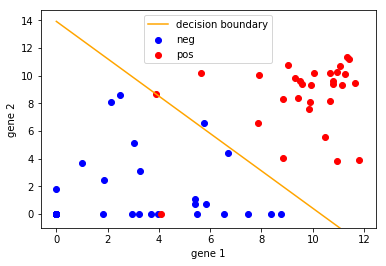

In [79]:
plotDecisionBoundary(optimal_theta, X, y)

This seems like a very sensible decision boundary.

## Prediction and Accuracies

The ML course instructed us to create a predict function and then use that to compute the accuracy of the predicted classification.

In [38]:
# Prediction function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta)).flatten()
    p = h >= 0.5
    return p

In [39]:
# Compute accuracy on our training set
p = predict(optimal_theta, X);
print('Train Accuracy: ', np.mean(p == y) * 100);

Train Accuracy:  97.2602739726


## Using scikit-learn's logistic regression and regularization

Let's look at the default theta values that are produced when using the [logistic regression function from scikit-learn (SKL)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and compare with the thetas we calculated with `fmin_tnc` optimization.

In [80]:
from sklearn.linear_model import LogisticRegression

In [98]:
# Instantiate a logistic regression model, and fit with X and y 
model = LogisticRegression()
model = model.fit(X, y)

In [99]:
print('Thetas from SKL logistic regression: ', model.coef_[0])
print('Thetas found by fmin_tnc function: ', result[0]);

Thetas from SKL logistic regression:  [-1.93428654  0.36535035  0.35153828]
Thetas found by fmin_tnc function:  [-7.65282614  0.74252063  0.54925607]


Why are the values different using the SKL approach versus what we determined using our optimization function? If one were to use default parameter values of SKL logistic regression, it might be easy to overlook that L2 (ridge) regularization is used as a default for this function. The optimal thetas we determined above with `fmin_tnc` did not use regularization. While regularization is not necessary in this simplified (two-feature) case, it can be used to minimize overfitting when datasets have many features.

The logistic regression cost function with L2 regularization as taught in the ML course is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{(i)}))-(1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta^2_{j} $$

How do we turn off regularization in the SKL function? SKL does not allow us to remove regularization directly, but we can nullify the regularization term by setting lambda to zero. The SKL function controls regularization strength by the parameter `C` which is inversely proportional to lambda. Therefore, one must [set the C value to be large](https://stackoverflow.com/questions/25427650/sklearn-logisticregression-without-regularization) to drive the regularization parameter towards 0. 

In [100]:
c_values = [10**i for i in range(6)]
print(c_values)

[1, 10, 100, 1000, 10000, 100000]


In [103]:
for i in c_values:
    model_wreg = LogisticRegression(C=i)
    model_wreg = model_wreg.fit(X, y)
    print('C = ', i, '\t SKL thetas: ', model_wreg.coef_[0])
print('Thetas found by fmin_tnc function: ', result[0])

C =  1 	 SKL thetas:  [-1.93428654  0.36535035  0.35153828]
C =  10 	 SKL thetas:  [-3.18925315  0.6161684   0.4764179 ]
C =  100 	 SKL thetas:  [-3.73121761  0.72361884  0.53807019]
C =  1000 	 SKL thetas:  [-3.81569535  0.74039178  0.54798173]
C =  10000 	 SKL thetas:  [-3.82468845  0.742178    0.54904109]
C =  100000 	 SKL thetas:  [-3.82559369  0.7423578   0.54914777]
Thetas found by fmin_tnc function:  [-7.65282614  0.74252063  0.54925607]


As you can see, the $\theta_1$ and $\theta_2$ values match nearly exactly. The $\theta_0$ values differ by exactly a factor of 2, which is reflective of an [optional factor](https://stats.stackexchange.com/questions/57628/why-is-the-logistic-regression-cost-function-scaled-by-the-number-of-examples) to include in the calculation.

## Conclusion

Others had translated the MATLAB code to Python for the assignment of the course. Check out those Python implementations I found ([here](http://aimotion.blogspot.com/2011/11/machine-learning-with-python-logistic.html), [here](http://nbviewer.jupyter.org/github/tfolkman/learningwithdata/blob/master/Logistic%20Gradient%20Descent.ipynb), and [here](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/)) which also helped me as I was doing this small project. 

In this post, I chose a subset of data from a personal project, implemented step-by-step logistic regression by translating MATLAB code to Python, and compared the theta values produced by the optimization function to the theta values derived from scikit-learn's logistic regression function. This provided an opportunity to re-inforce lessons from the Machine Learning course. Seeing how the two methods arrive at the same values also provided cross-confirmation for me.

Scikit-learn is an amazing package and for most technical projects, you would not write out your own logistic regression function. But writing the function and comparing values helps make the SKL logistic regression a little bit less of a black box.

*This post was originally created on March 18, 2018.*